# Strategie de la Moyenne Mobile sur l'indice BRVM-Agriculture

## importation des bibliotheques


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from print_color import print
import locale 
from datetime import datetime
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')


'fr_FR.UTF-8'

In [5]:
BRVM = pd.read_csv("../data/BRVM-Agriculture.csv",index_col="Date")

In [6]:
debut = -365
fin = len(BRVM)
brvm = BRVM.iloc[debut:]

### Calcul des moyennes mobiles longues et courtes

In [ ]:
# creation de de colonne de moyenne mobile

# moyenne mobile rapide / court terme
brvm["MA10"] = brvm["Close"].rolling(6).mean() #10

# moyenne mobile lente / long terme
brvm["MA50"] = brvm["Close"].rolling(10).mean() #40

brvm = brvm.dropna() ;

In [ ]:
# creation de la liste position
condition = [brvm["MA10"]>brvm["MA50"] , brvm["MA10"]<brvm["MA50"]]
# creation d'une liste choix de deux element
choix = [1,0]
# 
brvm['P'] = np.select(condition, choix)

In [9]:
brvm

,Dernier,Ouv.,Plus Haut,Plus Bas,Variation %,Close,High,Low,Open,MA10,MA50,P
Date,,,,,,,,,,,,
10/12/2021,"239,07","238,03","239,45","239,07","0,44%",239.07,239.45,239.07,238.03,240.468333,243.829,0
13/12/2021,"232,63","239,07","239,52","232,63","-2,69%",232.63,239.52,232.63,239.07,238.586667,242.297,0
14/12/2021,"239,07","232,63","239,20","232,63","2,77%",239.07,239.20,232.63,232.63,237.920000,241.368,0
15/12/2021,"242,00","239,07","242,14","239,07","1,23%",242.00,242.14,239.07,239.07,238.406667,240.656,0
16/12/2021,"239,63","242,00","242,20","239,63","-0,98%",239.63,242.20,239.63,242.00,238.405000,239.614,0
...,...,...,...,...,...,...,...,...,...,...,...,...
09/05/2023,"260,09","263,37","263,37","260,09","-1,25%",260.09,263.37,260.09,263.37,263.245000,266.424,0
10/05/2023,"253,34","260,09","263,07","247,71","-2,60%",253.34,263.07,247.71,260.09,261.780000,264.204,0
11/05/2023,"251,77","253,34","254,20","243,82","-0,62%",251.77,254.20,243.82,253.34,259.651667,261.682,0


### Vérification des conditions d'achat et de vente du marché

A l'entré sur le marché nous ne pocédons pas de stock.
Au premier signal d'achat nous achetons des actifs.
Si il y a d'autre signal d'achat nous n'achetons pas car nous avons déja des actifs. 
De meme nous ne vendons pas si nous n'avons pas de stock en cas de signal de vente

In [ ]:
condition = []
signal_achat = []
signal_vente = []
date_1 = brvm.index[0]
stock = 0 # permet d'eviter d'acheter quand on pas de stock au debut

for date in brvm.index :
    if brvm["MA10"].loc[date] > brvm["MA50"].loc[date] :
        condition.append(1)
    else :
        condition.append(0)
    
    if( brvm["MA10"].loc[date] > brvm["MA50"].loc[date] ) and (brvm["MA10"].loc[date_1] < brvm["MA50"].loc[date_1]) and stock == 0:
        signal_achat.append(brvm["Close"].loc[date])
        stock = 1

    else :
        signal_achat.append(np.nan)

    
    if( brvm["MA10"].loc[date] < brvm["MA50"].loc[date] ) and (brvm["MA10"].loc[date_1] > brvm["MA50"].loc[date_1]) and (stock == 1):
        signal_vente.append(brvm["Close"].loc[date])
        stock = 0
    else :
        signal_vente.append(np.nan)
        
    date_1 = date

brvm["Position"] = condition
        


In [11]:
for i in range(len(brvm)-1 , 0 , -1 ) :
    if signal_achat[i] > 0 :
        signal_achat[i] = np.nan
        break
        

In [ ]:
achat_vente = []
stock = 0
for i in range( len(brvm) ) :
    if signal_achat[i] > 0 and stock != 1:
        achat_vente.append('acheter')
        stock = 1
    elif signal_vente[i] > 0 and stock != 0 :
        achat_vente.append('vendre' )
        stock=0
    else :
        achat_vente.append(np.nan)

brvm['achat_vente'] = achat_vente

Text(0, 0.5, 'Prix de cloture des actions brvm')

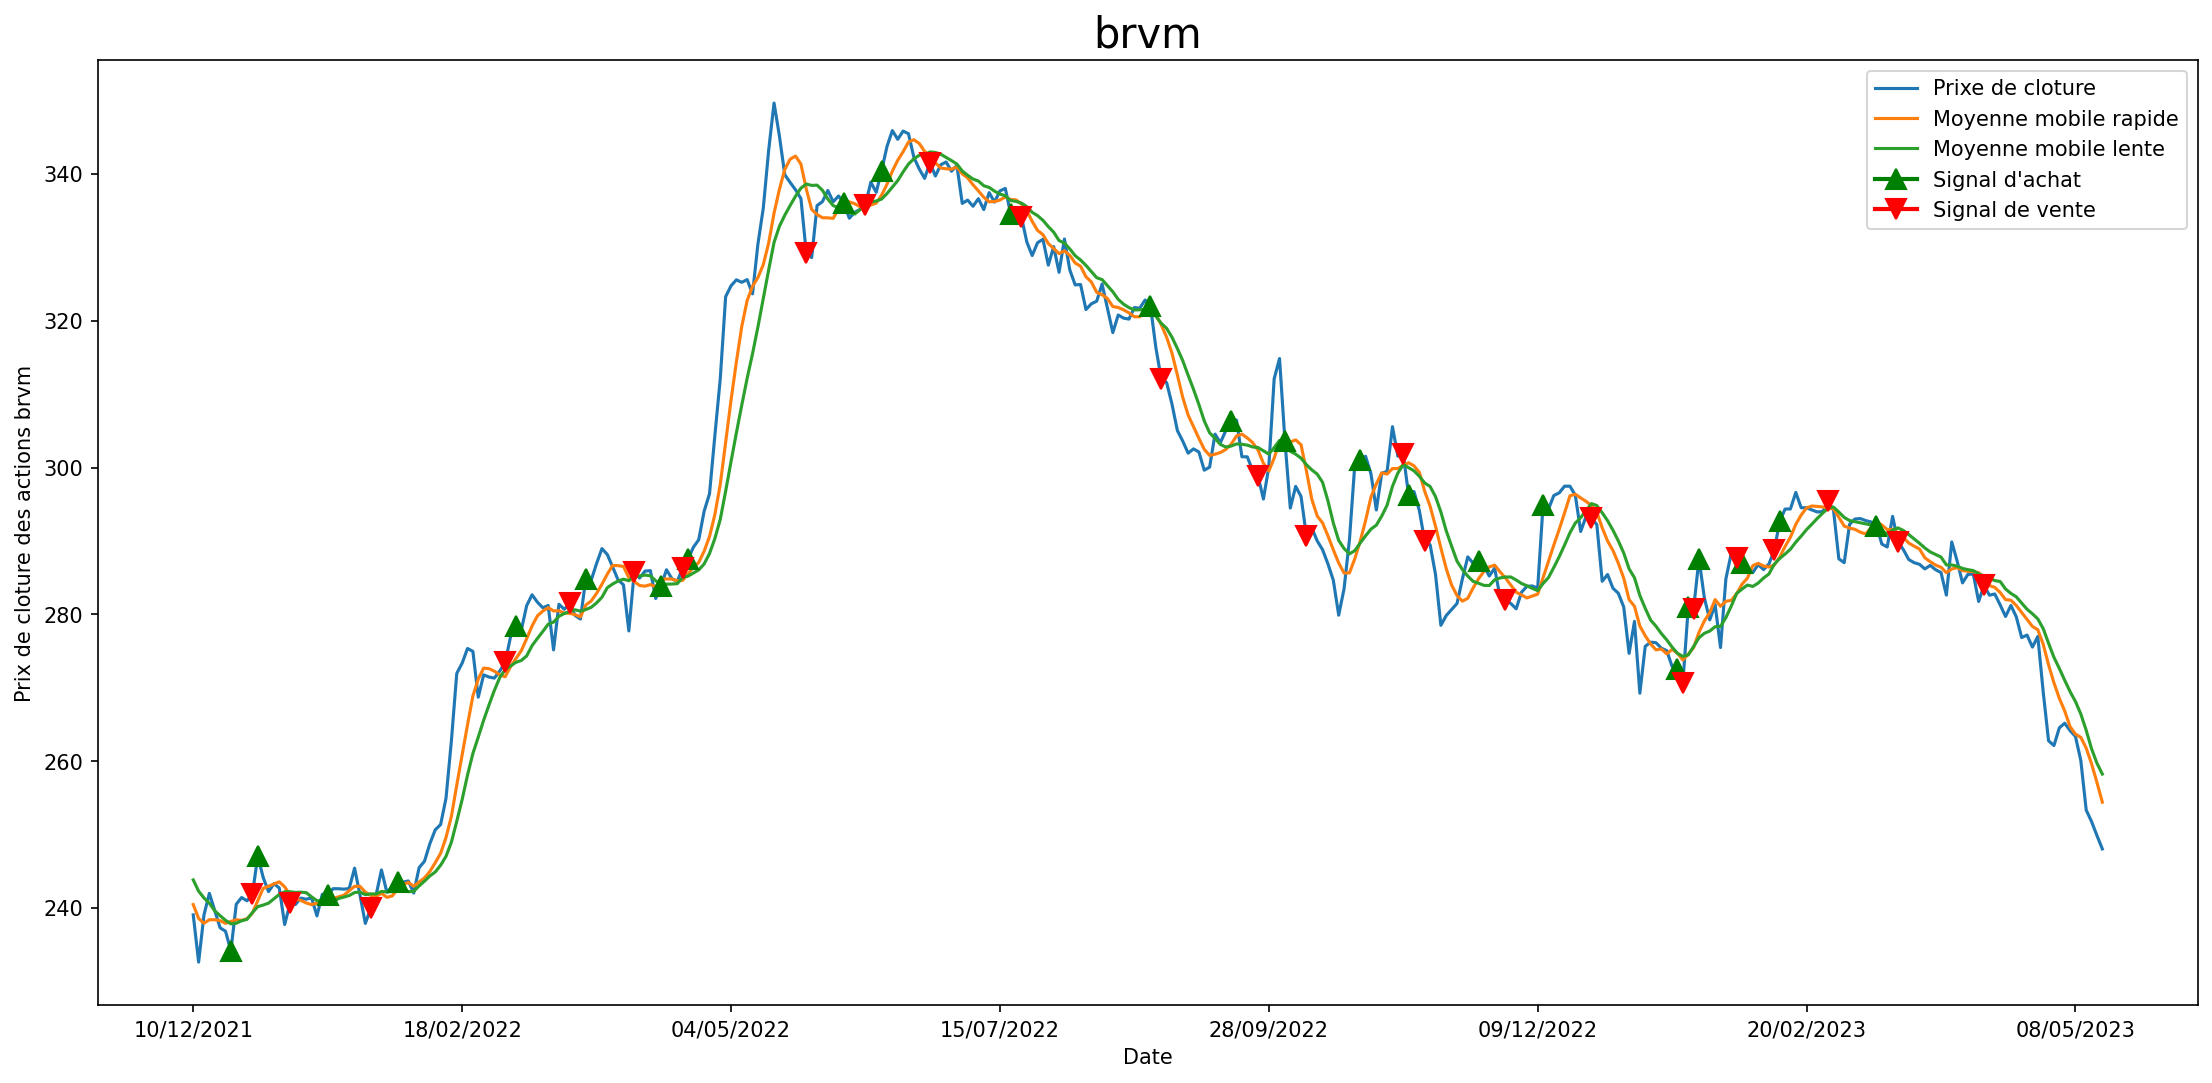

In [13]:
fig = plt.figure(figsize=(14,7), dpi=150)

axe1 = fig.add_axes([0,1,1,0.9])

axe1 = brvm["Close"].plot(label='Prixe de cloture') 
axe1 = brvm["MA10"].plot(label='Moyenne mobile rapide')
axe1 = brvm["MA50"].plot(label='Moyenne mobile lente')

axe1.plot(brvm.index , signal_achat , marker='^',color='green',markersize=10,label = "Signal d'achat",linewidth=2)
axe1.plot(brvm.index , signal_vente , marker='v',color='red',markersize=10,label = "Signal de vente",linewidth=2)

axe1.legend()
axe1.set_title("brvm" , fontsize=20) 
axe1.set_ylabel("Prix de cloture des actions brvm")


## Backtesting

In [14]:
benefice = 0
depart = 1000
d = depart
nombre = 0
total = 0

for i in range( len( brvm ) ) :
    if brvm['achat_vente'].iloc[i] == 'acheter' :

        nombre = depart/brvm['Close'].iloc[i]
        entrer = nombre*brvm['Close'].iloc[i]

    elif brvm['achat_vente'].iloc[i] == 'vendre' :

        sorti = (nombre*brvm['Close'].iloc[i])
        benefice += sorti-entrer
        
        total += sorti
        depart = sorti
    else :
        pass

pourcentage_befice = 100*(benefice/d)

## Resulatats du backtesting

In [15]:
date_depart = datetime.strptime(BRVM.iloc[debut].name , "%d/%m/%Y" ).strftime("%A %d %B, %Y ")
date_fin = datetime.strptime(BRVM.iloc[fin-1].name , "%d/%m/%Y" ).strftime("%A %d %B, %Y ")

print("Avec un capitale de depart de " ,end="")
print("{:,.2f} Fcfa".format(d) , color='green')
print("nous avons réalisé un benefice de ",end='')
print("{:.2f} %".format(pourcentage_befice) , color='green')
print("Soit un benefice total de ",end='')
print("{:,.2f} Fcfa".format(benefice) , color='green')
print("Sur la periode allant du ",end='')
print(date_depart , color="blue" , end="") ; print(" au " ,end="")
print(date_fin , color="blue" , end="")


Avec un capitale de depart de 1,000.00 Fcfa
nous avons réalisé un benefice de 13.92 %
Soit un benefice total de 139.16 Fcfa
Sur la periode allant du lundi 29 novembre, 2021  au lundi 15 mai, 2023 